In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
import os
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)


In [4]:
# load data
cd = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
shp = gpd.read_file(cd + "/icrisat_boundary_match.shp")[['NAME_1', 'Name_12', 'Dist_Name', 'Shape_Area', 'geometry']]
df_raw = pd.read_csv( cd+ "/yield_csif_2017.csv").iloc[:, 1:]
df = df_raw[(df_raw["year"].between(2000, 2022)) & df_raw["yield"].notna() & np.isfinite(df_raw["yield"])]
df = df[(df["cropname"] == "Wheat") & (~df["Name_12"].isin(["Bombay", "Guntur", "Krishna", "Mysore", "The Nilgiris"]))]
yield_mean = df["yield"].mean(skipna=True)

/var/folders/k4/2gcvspsj7d7c9hbxlvzv_zrh0000gn/T/ipykernel_31917/800404684.py:4: DtypeWarning: Columns (9,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv( cd+ "/yield_csif_2017.csv").iloc[:, 1:]


In [36]:
# Define predictor (X) and response variable (y)
X = df[["sm", "tmax", "year", "Name_12"]].copy()  # Copy ensures modifications don’t affect original df
y = np.log(df["yield"] + yield_mean)  # Compute response variable

# Convert categorical variable "Name_12" into dummy variables
X = pd.get_dummies(X, columns=["Name_12"], drop_first=True)  # One-hot encoding

# Drop rows where X or y contain NaN or Inf
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]  # Ensure y matches the cleaned X

# Add constant (intercept)
X = sm.add_constant(X)

# Fit OLS model
mod_climate_dist = sm.OLS(y, X).fit()

# Print summary
print(mod_climate_dist.summary())


                            OLS Regression Results                            
Dep. Variable:                  yield   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     109.3
Date:                Sat, 15 Mar 2025   Prob (F-statistic):               0.00
Time:                        15:03:43   Log-Likelihood:                 5771.7
No. Observations:                5980   AIC:                        -1.096e+04
Df Residuals:                    5689   BIC:                            -9013.
Df Model:                         290                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [41]:
# Ensure df has only the required predictors
X_pred = df[["sm", "tmax", "year", "Name_12"]].copy()

# Convert categorical variable "Name_12" into dummy variables
X_pred = pd.get_dummies(X_pred, columns=["Name_12"], drop_first=True)

# Add constant to match training data
X_pred = sm.add_constant(X_pred)

# Ensure no NaNs or mismatched rows
X_pred = X_pred.replace([np.inf, -np.inf], np.nan).dropna()

# Predict yield
df.loc[X_pred.index, "predicted_yield"] = mod_climate_dist.predict(X_pred)

# Correct transformation back to original scale
df.loc[X_pred.index, 'predicted_yield'] = np.exp(df.loc[X_pred.index, 'predicted_yield']) - yield_mean

# Compute yield shortfall
df.loc[X_pred.index, "yield_shortfall"] = df.loc[X_pred.index, "yield"] - df.loc[X_pred.index, "predicted_yield"]

# Aggregate by district
mod_plot = df.groupby("Name_12").agg(
    yield_mean=("yield", "mean"),
    yield_pred_mean=("predicted_yield", "mean")
).reset_index()

# Compute shortfall in original scale
mod_plot["yield_shortfall"] = mod_plot['yield_pred_mean'] - mod_plot["yield_mean"]

# Merge with spatial data
mod_plot = shp.merge(mod_plot, on="Name_12")
mod_plot = gpd.GeoDataFrame(mod_plot)



In [45]:
def plot_map(data, fill_var, title, cmap, limits):
    fig, ax = plt.subplots(figsize=(8, 12))
    data.plot(column=fill_var, cmap=cmap, vmin=limits[0], vmax=limits[1], linewidth=0.8, edgecolor="black", legend=True, ax=ax)
    
    ax.set_title(title, fontsize=20)
    ax.axis("off")
    plt.show()


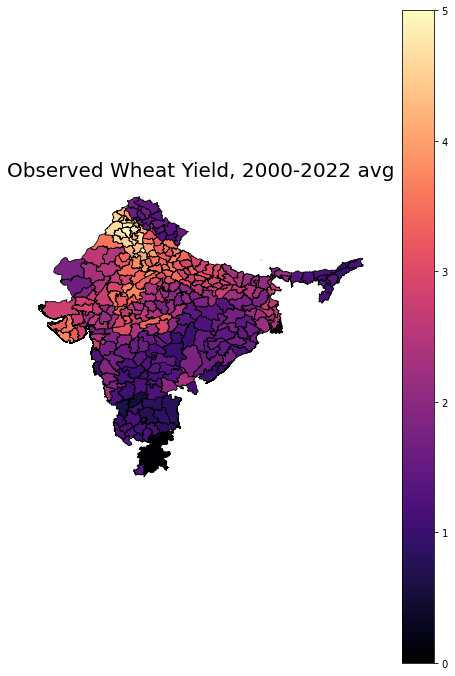

In [47]:
plot_map(
    mod_plot,
    fill_var="yield_mean",
    title="Observed Wheat Yield, 2000-2022 avg",
    cmap="magma",
    limits=(0, 5))


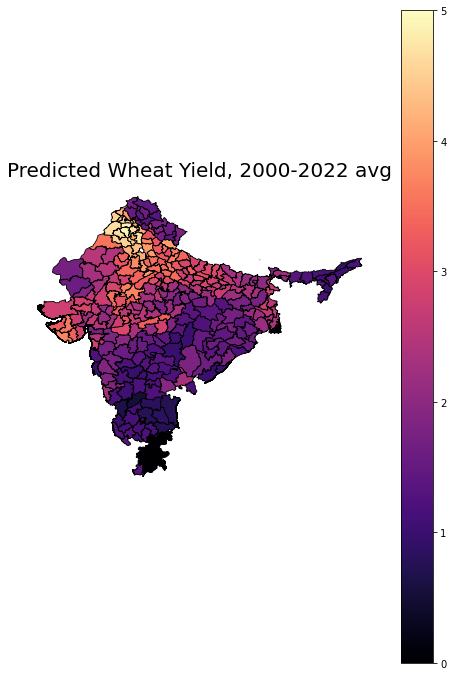

In [48]:
plot_map(
    mod_plot,
    fill_var="yield_pred_mean",
    title="Predicted Wheat Yield, 2000-2022 avg",
    cmap="magma",
    limits=(0, 5))


### now taking out districts and just predicting using climate variables

In [57]:
# Define predictor (X) and response variable (y)
X = df[["sm", "tmax", "year"]].copy()  # Copy ensures modifications don’t affect original df
y = np.log(df["yield"] + yield_mean)  # Compute response variable

# Drop rows where X or y contain NaN or Inf
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]  # Ensure y matches the cleaned X

# Add constant (intercept)
X = sm.add_constant(X)

# Fit OLS model
mod_climate = sm.OLS(y, X).fit()

# Print summary
print(mod_climate.summary())


                            OLS Regression Results                            
Dep. Variable:                  yield   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     728.2
Date:                Sat, 15 Mar 2025   Prob (F-statistic):               0.00
Time:                        15:07:52   Log-Likelihood:                 1074.7
No. Observations:                5980   AIC:                            -2141.
Df Residuals:                    5976   BIC:                            -2115.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -21.2217      0.796    -26.662      0.0

In [67]:
# Ensure df has only the required predictors
X_pred = df[["sm", "tmax", "year"]].copy()

# Add constant to match training data
X_pred = sm.add_constant(X_pred)

# Ensure no NaNs or mismatched rows
X_pred = X_pred.replace([np.inf, -np.inf], np.nan).dropna()

# Predict yield
df.loc[X_pred.index, "predicted_yield"] = mod_climate_dist.predict(X_pred)

# Correct transformation back to original scale
df.loc[X_pred.index, 'predicted_yield'] = np.exp(df.loc[X_pred.index, 'predicted_yield']) - yield_mean

# Compute yield shortfall
df.loc[X_pred.index, "yield_shortfall"] = df.loc[X_pred.index, "yield"] - df.loc[X_pred.index, "predicted_yield"]

# Aggregate by district
mod_plot = df.groupby("Name_12").agg(
    yield_mean=("yield", "mean"),
    yield_pred_mean=("predicted_yield", "mean"),
    yield_shortfall_mean = ("yield_shortfall", "mean")
).reset_index()

# Merge with spatial data
mod_plot = shp.merge(mod_plot, on="Name_12")
mod_plot = gpd.GeoDataFrame(mod_plot)



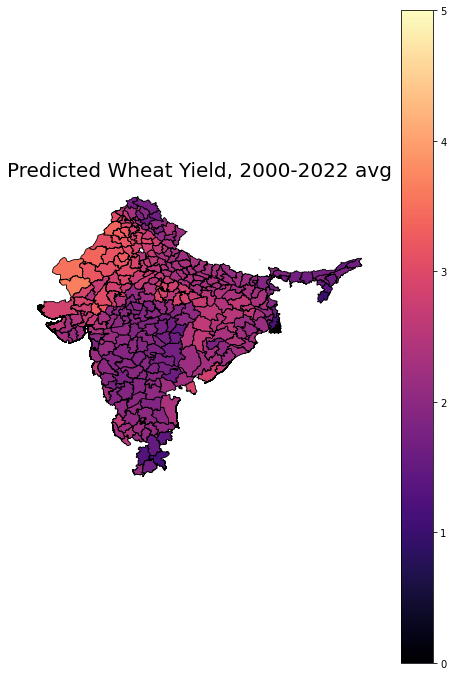

In [61]:
plot_map(
    mod_plot,
    fill_var="yield_pred_mean",
    title="Predicted Wheat Yield, 2000-2022 avg",
    cmap="magma",
    limits=(0, 5))

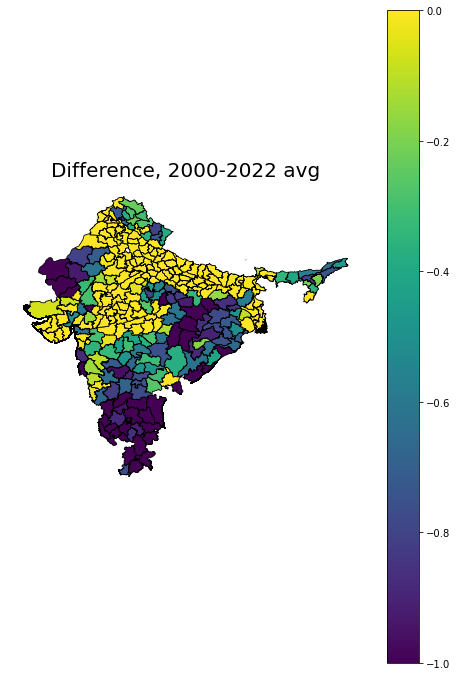

In [69]:
plot_map(
    mod_plot,
    fill_var="yield_shortfall_mean",
    title="Difference, 2000-2022 avg",
    cmap="viridis",
    limits=(-1, 0))